In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
from IPython.display import display, IFrame

def show_bootstrapping_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vS_iYHJYXSVMMZ-YQVFwMEFR6EFN3FDSAvaMyUm-YJfLQgRMTHm3vI-wWJJ5999eFJq70nWp2hyItZg/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 509
    display(IFrame(src, width, height))

# Lecture 19 – Bootstrapping, Percentiles, and Confidence Intervals

## DSC 10, Fall 2022

### Announcements

- Homework 5 is due **Tuesday 11/8 at 11:59pm**.
- Lab 6 is due **Saturday 11/12 at 11:59pm**.
- We'll be releasing the Final Project this week.
    - Get a partner lined up! You don't have to work with your partner from the Midterm Project.
- Come hang out with your instructors:
    - On Wednesday 11/9 from 5-6pm in CSE 4140, come watch Suraj participate in "Professor Talks: Spicy Challenge 🌶" with faculty from CSE. See more details [here](https://twitter.com/niemasd/status/1588658101787717632?s=20&t=4FRjNgZl8d_-ZHua8SLpnQ).
    - On Tuesday 11/15 from 10-11am in the SDSC Auditorium, come talk to Janine, Suraj, and other HDSI faculty at the HDSI faculty/student mixer!

### Agenda 

- Bootstrapping.
- Percentiles.
- Confidence intervals.



### Resources

- You may have noticed that we've quickly moved into much more theoretical material. 

- Remember to read the [textbook](https://inferentialthinking.com/chapters/intro.html) for more context and examples.

- Additionally, [this site](https://www.jwilber.me/permutationtest/) contains a helpful visual explanation of permutation testing.

## Bootstrapping 🥾

### City of San Diego employee salary data

All City of San Diego employee salary data [is public](https://publicpay.ca.gov/Reports/Cities/City.aspx?entityid=405&year=2021&rpt=1). We are using the latest available data.

In [2]:
population = bpd.read_csv('data/2021_salaries.csv')
population

,Year,EmployerType,EmployerName,DepartmentOrSubdivision,...,EmployerCounty,SpecialDistrictActivities,IncludesUnfundedLiability,SpecialDistrictType
0,2021,City,San Diego,Police,...,San Diego,NaN,False,NaN
1,2021,City,San Diego,Police,...,San Diego,NaN,False,NaN
2,2021,City,San Diego,Police,...,San Diego,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
12302,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN
12303,2021,City,San Diego,Fleet Operations,...,San Diego,NaN,False,NaN
12304,2021,City,San Diego,Fire-Rescue,...,San Diego,NaN,False,NaN


We only need the `'TotalWages'` column, so let's `get` just that column.

In [3]:
population = population.get(['TotalWages'])
population

,TotalWages
0,359138
1,345336
2,336250
...,...
12302,9
12303,9
12304,4


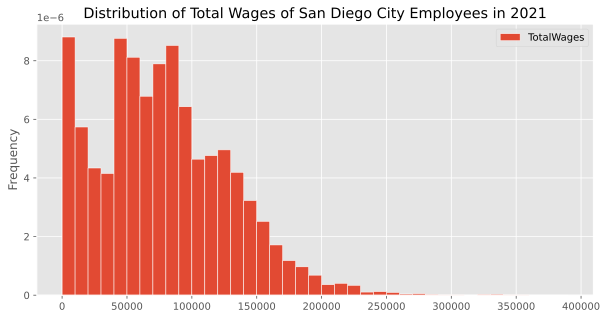

In [4]:
population.plot(kind='hist', bins=np.arange(0, 400000, 10000), density=True, ec='w', figsize=(10, 5),
                title='Distribution of Total Wages of San Diego City Employees in 2021');

### The median salary

- We can use `.median()` to find the median salary of all city employees.
- This is **not** a random quantity.

In [5]:
population_median = population.get('TotalWages').median()
population_median

74441.0

### Let's be realistic...

- In practice, it is costly and time-consuming to survey **all** 12,000+ employees.
    - More generally, we can't expect to survey all members of the population we care about.

- Instead, we gather salaries for a random sample of, say, 500 people.

- Hopefully, the median of the sample is close to the median of the population.

### In the language of statistics

- The full DataFrame of salaries is the **population**.

- We observe a **sample** of 500 salaries from the population.

- We want to determine the **population median (a parameter)**, but we don't have the whole population, so instead we use the **sample median (a statistic) as an estimate**.

- Hopefully the sample median is close to the population median.

### The sample median

Let's survey 500 employees at random. To do so, we can use the `.sample` method.

In [6]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

# Take a sample of size 500.
my_sample = population.sample(500)
my_sample

,TotalWages
599,167191
10595,18598
837,157293
...,...
2423,122785
7142,62808
5792,78093


We won't reassign `my_sample` at any point in this notebook, so it will always refer to this particular sample.

In [7]:
# Compute the sample median.
sample_median = my_sample.get('TotalWages').median()
sample_median

72016.0

### How confident are we that this is a good estimate?

- Our estimate depended on a random sample.

- If our sample was different, our estimate may have been different, too.

- **How different could our estimate have been?**

- Our confidence in the estimate depends on the answer to this question.

### The sample median is random

- The sample median is a random number.

- It comes from some distribution, which we don't know.

- How different could our estimate have been, if we drew a different sample?
    - "Narrow" distribution $\Rightarrow$ not too different.
    - "Wide" distribution $\Rightarrow$ quite different.

- **What is the distribution of the sample median?**

### An impractical approach

- One idea: repeatedly collect random samples of 500 **from the population** and compute their medians.
    - This is what we did in Lecture 14 to compute an empirical distribution of the sample mean of flight delays.

In [8]:
sample_medians = np.array([])
for i in np.arange(1000):
    median = population.sample(500).get('TotalWages').median()
    sample_medians = np.append(sample_medians, median)
sample_medians

array([81062.5, 77915.5, 70419.5, ..., 71840. , 73618.5, 79238. ])

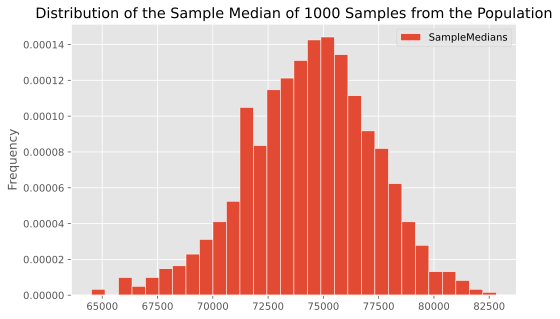

In [9]:
(bpd.DataFrame()
 .assign(SampleMedians=sample_medians)
 .plot(kind='hist', density=True,
       bins=30, ec='w', figsize=(8, 5),
       title='Distribution of the Sample Median of 1000 Samples from the Population')
);

- This shows an empirical distribution of the sample median. It is an approximation of the true probability distribution of the sample median, based on 1000 samples.

### The problem

- Drawing new samples like this is impractical.
    - If we were able to do this, why not just collect more data in the first place?
- Often, we can't ask for new samples from the population.

- **Key insight:** our original sample, `my_sample`, looks a lot like the population.
    - Their distributions are similar.

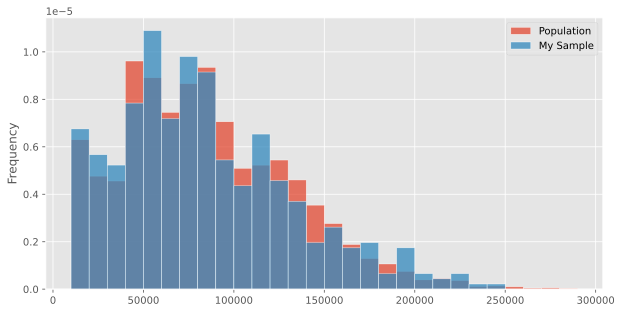

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
bins=np.arange(10_000, 300_000, 10_000)
population.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
my_sample.plot(kind='hist', y='TotalWages', ax=ax, density=True, alpha=.75, bins=bins, ec='w')
plt.legend(['Population', 'My Sample']);

Note that unlike the previous histogram we saw, this is depicting the distribution of the population and of one particular sample (`my_sample`), **not** the distribution of sample medians for 1000 samples.

### The bootstrap

- **Shortcut:** Use the sample in lieu of the population.
    - The sample itself looks like the population.
    - So, resampling from the sample is kind of like sampling from the population.
    - The act of resampling from a sample is called **bootstrapping** or "**the bootstrap**" method.

- In our case specifically:
    - We have a sample of 500 salaries.
    - We want another sample of 500 salaries, but we can't draw from the population.
    - However, the original sample looks like the population.
    - So, let's just **resample from the sample!**

In [12]:
show_bootstrapping_slides()

### To replace or not replace?

- Our goal when bootstrapping is to create a sample of the same size as our original sample. 

- Let's repeatedly resample 3 numbers **without replacement** from an original sample of [1, 2, 3].

In [13]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=False)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [1 3 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [2 3 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 2 1]     Median:  2.0
Resample:  [1 2 3]     Median:  2.0
Resample:  [3 1 2]     Median:  2.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [2 1 3]     Median:  2.0


- Let's repeatedly resample 3 numbers **with replacement** from an original sample of [1, 2, 3].

In [14]:
original = [1, 2, 3]
for i in np.arange(10):
    resample = np.random.choice(original, 3, replace=True)
    print("Resample: ", resample, "    Median: ", np.median(resample))

Resample:  [2 3 3]     Median:  3.0
Resample:  [3 1 3]     Median:  3.0
Resample:  [2 2 3]     Median:  2.0
Resample:  [2 3 1]     Median:  2.0
Resample:  [3 3 3]     Median:  3.0
Resample:  [1 3 2]     Median:  2.0
Resample:  [1 2 1]     Median:  1.0
Resample:  [3 3 2]     Median:  3.0
Resample:  [3 3 1]     Median:  3.0
Resample:  [1 1 3]     Median:  1.0


- When we resample without replacement, resamples look just like the original samples.

- When we resample with replacement, resamples can have a different mean, median, max, and min than the original sample.

- So, we need to sample **with replacement** to ensure that our resamples can be different from the original sample.

### Running the bootstrap

We can simulate the act of collecting new samples by **sampling with replacement from our original sample, `my_sample`**.

In [15]:
# Note that the population DataFrame doesn't appear anywhere here.
# This is all based on one sample.

n_resamples = 5000
boot_medians = np.array([])

for i in range(n_resamples):
    
    # Resample from my_sample WITH REPLACEMENT.
    resample = my_sample.sample(500, replace=True)
    
    # Compute the median.
    median = resample.get('TotalWages').median()
    
    # Store it in our array of medians.
    boot_medians = np.append(boot_medians, median)

In [16]:
boot_medians

array([72538. , 70989.5, 71874. , ..., 71372. , 69750. , 71486.5])

### Bootstrap distribution of the sample median

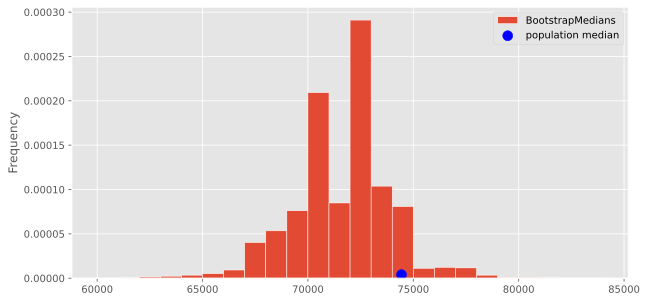

In [17]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', 
                                                           density=True, 
                                                           bins=np.arange(60000, 85000, 1000), 
                                                           ec='w', 
                                                           figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend();

- The population median (<span style="color:blue"><b>blue dot</b></span>) is near the middle.
    - **In reality, we'd never get to see this!**

### What's the point of bootstrapping?

We have a sample median wage:

In [18]:
my_sample.get('TotalWages').median()

72016.0

With it, we can say that the population median wage is approximately \\$72,016, and not much else.

But by bootstrapping, we can generate an empirical distribution of the sample median:

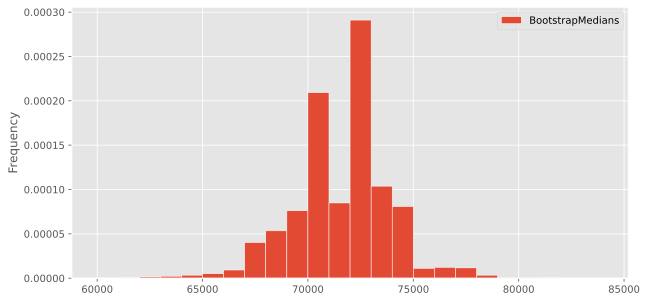

In [19]:
(bpd.DataFrame()
 .assign(BootstrapMedians=boot_medians)
 .plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
)
plt.legend();

which allows us to say things like

> We think the population median wage is between \\$67,000 and \\$77,000.

**Question:** We could also say that we think the population median wage is between \\$70,000 and \\$75,000, or between \\$60,000 and \\$80,000. What range should we pick?

## Percentiles

### Mathematical definition

> Let $p$ be a number between 0 and 100. The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 

By this definition, any percentile between 0 and 100 can be computed for any collection of values and is **always an element of the collection.** 

### How to calculate percentiles using mathematical definition

Suppose there are $n$ elements in the collection. To find the $p$th percentile:

1. Sort the collection in increasing order.

2. Define $h$ to be $p\%$ of $n$: 

$$h = \frac p{100} \cdot n$$

3. If $h$ is an integer, define $k = h$. Otherwise, let $k$ be the smallest integer greater than $h$.

4. Take the $k$th element of the sorted collection (start counting from 1, not 0).

### Example

What is the 25th percentile of the array `np.array([4, 10, 15, 21, 100])`?

<br>

<details><summary>Click <b>here</b> to see the solution.</summary>
    
<ol>
  <li>First, we need to sort the collection in increasing order. Conveniently, it's already sorted!</li>
   <li>Define $h = \frac{p}{100} \cdot n$. Here, $p = 25$ and $n = 5$, so $h = \frac{25}{100} \cdot 5 = \frac{5}{4} = 1.25$.</li>
   <li>Since 1.25 is not an integer, $k$ must be the smallest integer greater than 1.25, which is 2.</li>
    <li>If we start counting at 1, the element at position 2 is <code>10</code>, so the 25th percentile is <code>10</code>.</li>
</ol>
    
</details>

### Reflection

Consider the array from the previous slide, `np.array([4, 10, 15, 21, 100])`. Here's how our percentile formula works:

| value       | 4       | 10       | 15       | 21       | 100      
|------------|---------|----------|----------|----------|-----------
| percentile | [0, 20] | (20, 40] | (40, 60] | (60, 80] | (80, 100]

For instance, the 8th percentile is `4`, the 50th percentile (median) is `15`, and the 79th percentile is `21`.

Notice that in the table above, each of the 5 values owns an equal percentage (20\%) of the range 0-100. `4` is the 20th percentile, but `10` is the 20.001st percentile.

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com)

What is the 70th percentile of the array `np.array([70, 18, 56, 89, 55, 35, 10, 45])`?

<center>
A. 35 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; B. 55 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; C. 56 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; D. 70 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; E. None of these
</center>

<br>

<details><summary>Click <b>here</b> to see the solution <b>after</b> you've tried it yourself.</summary>
    
<ol>
  <li>First, we need to sort the collection in increasing order. This gives us <code>np.array([10, 18, 35, 45, 55, 56, 70, 89])</code>.</li>
   <li>Define $h = \frac{p}{100} \cdot n$. Here, $p = 70$ and $n = 8$, so $h = \frac{70}{100} \cdot 8 = 5.6$.</li>
   <li>Since 5.6 is not an integer, $k$ must be the smallest integer greater than 5.6, which is 6.</li>
    <li>If we start counting at 1, the element at position 6 is <code>56</code>, so the 70th percentile is <code>56</code>.</li>
</ol>

### Calculating the percentile using our mathematical definition

In [20]:
def percentile(data, p):
    data = np.sort(data) # Returns a sorted copy of data.
    n = len(data)
    h = (p / 100) * n
    k = int(np.ceil(h)) # If h is an integer, this is h. Otherwise, it rounds up.
    return data[k - 1] # - 1 because Python is 0-indexed but regular math is 1-indexed.

In [21]:
example = np.array([70, 18, 56, 89, 55, 35, 10, 45])
percentile(example, 50)

45

In [22]:
percentile(example, 70)

56

### Another definition of percentile

- The `numpy` package provides a function to calculate percentiles, `np.percentile(array, p)`, which returns the `p`th percentile of `array`.
- `np.percentile` doesn't implement our version of percentile exactly, but for large arrays the two definitions are nearly the same.
- We'll usually use `np.percentile` since it's faster.

In [23]:
percentile(example, 50)

45

In [24]:
np.percentile(example, 50)

50.0

## Confidence intervals

### Using the bootstrapped distribution of sample medians

Earlier in the lecture, we generated a bootstrapped distribution of sample medians.

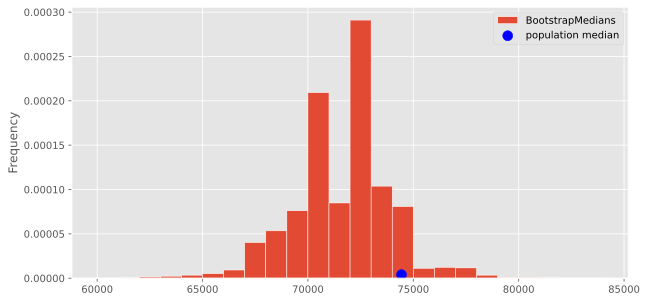

In [25]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(60000, 85000, 1000), ec='w', figsize=(10, 5))
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(2)
plt.legend();

What can we do with this distribution, now that we know about percentiles?

### Using the bootstrapped distribution of sample medians

- We have a sample median, \\$72,016.

- As such, we think the population median is close to \\$72,016. However, we're not quite sure _how_ close.

- How do we capture our uncertainty about this guess?

- 💡 **Idea:** Find a range that captures **most** (e.g. 95%) of the bootstrapped distribution of sample medians.

### Confidence intervals

Let's be a bit more precise.

- Goal: estimate an unknown population parameter.

- We have been saying 
> We think the population parameter is close to our sample statistic, $x$.

- We want to say 
> We think the population parameter is between $a$ and $b$.

- To do this, we'll use the bootstrapped distribution of a sample statistic to compute an **interval** that contains "the bulk" of the sample statistics. Such an interval is called a **confidence interval**.

### Finding endpoints

- We want to find two points, $x$ and $y$, such that:
    - The area to the left of $x$ is about 2.5%.
    - The area to the right of $y$ is about 2.5%.

- The interval $[x,y]$ will contain about 95% of the total area, i.e. 95% of the total values. As such, we will call $[x, y]$ a **95% confidence interval**.

- $x$ and $y$ are the **2.5th percentile** and **97.5th percentile**, respectively.

### Computing a confidence interval

In [26]:
boot_medians

array([72538. , 70989.5, 71874. , ..., 71372. , 69750. , 71486.5])

In [27]:
# Left endpoint.
left = np.percentile(boot_medians, 2.5)
left

67081.0

In [28]:
# Right endpoint.
right = np.percentile(boot_medians, 97.5)
right

76271.0

In [29]:
# Therefore, our interval is:
[left, right]

[67081.0, 76271.0]

You will use the code above **very** frequently moving forward!

### Visualizing our 95% confidence interval

- Let's draw the interval we just computed on the histogram.
- 95% of the bootstrap medians fell into this interval.

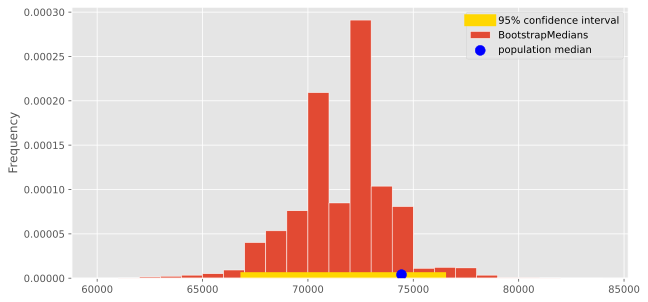

In [30]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', 
                                                           density=True, 
                                                           bins=np.arange(60000, 85000, 1000), 
                                                           ec='w', figsize=(10, 5), zorder=1)
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval', zorder=2);
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median', zorder=3)
plt.legend();

- In this case, our 95% confidence interval (<span style="color:gold"><b>gold line</b></span>) contains the true population parameter (<span style="color:blue"><b>blue dot</b></span>).
    - It won't always, because you might have a bad original sample!
    - In reality, you won't know where the population parameter is, and so you won't know if your confidence interval contains it.
- Note that the histogram is **not** centered around the population median (\\$74,441), but it is centered around the sample median (\\$72,016).

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com)

We computed the following 95% confidence interval:

In [31]:
print('Interval:', [left, right])
print('Width:', right - left)

Interval: [67081.0, 76271.0]
Width: 9190.0


If we instead computed an 80% confidence interval, would it be wider or narrower?

<center>
A. Wider &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; B. Narrower &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; C. Impossible to tell
</center

### Reflection

Now, instead of saying

> We think the population median is close to our sample median, \\$72,016.

We can say:

> A 95% confidence interval for the population median is \\$67,081 to \\$76,383.

_These endpoints may be slightly different than the endpoints we found, due to randomness._

Some lingering questions: What does 95% confidence mean? What are we confident about? Is this technique always "good"?

## Summary, next time

### Summary

- By bootstrapping a single sample, we can generate an empirical distribution of a sample statistic. This distribution gives us a sense of how different the sample statistic could have been if we had collected a different original sample.
- The $p$th percentile of a collection is the smallest value in the collection that is *at least as large* as $p$% of all the values. 
- After using the bootstrap to generate the empirical distribution of a sample statistic, we can create a $c$% confidence interval by taking the middle $c$% of values of the bootstrapped distribution.
- Such an interval allows us to **quantify the uncertainty** in our estimate of a population parameter.
    - Instead of providing just a single estimate of a population parameter, e.g. \\$72,016, we can provide a range of estimates, e.g. \\$67,081 to \\$76,383.
    - Confidence intervals are used in a variety of fields to capture uncertainty. For instance, political researchers create confidence intervals for the proportion of votes their favorite candidate will receive, given a poll of voters.

### Next time

We will:
- Give more context to what the confidence level of a confidence interval means.
- Look at statistics for which the bootstrap doesn't work well.
- Use confidence intervals for hypothesis testing.
- Start looking at measures of central tendency (mean, median, standard deviation).